In [1]:
%load_ext autoreload
%autoreload 2

<a href="https://www.kaggle.com/code/tornikeonoprishvili/fdtd-simulation?scriptVersionId=92832753" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# !pip install ../fdtd

In [3]:
# !pip install seaborn

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import pi
from numpy import sqrt

Some sim params:

First off, set $h = 10 nm$. Next, the $\frac{\omega}{cQ} = \frac{h}{\lambda}$ 

Now we have to select what the $\frac{h}{\lambda}$ is. This determines  and $\hat{\epsilon}$ and, $\lambda$ obviously.

So, let's set $\frac{h}{\lambda} = 0.53$ (No pass 

$\hat{\epsilon} = 1 - \frac{2q^2}{\omega^2m\epsilon_0} = 1 - 0.01 (\frac{h}{\lambda})^{-2}$  


So: 
1. h/l at .53, pass
2. h/l at .5425 block
3. h/l at .58 pass 

In [5]:
ratio = 0.53
h = 10e-9
lamd = h / ratio
k_0 = 1 - 0.01 * (h/lamd) ** -2 # Used for eps hat calculation

In [6]:
0.01 * (h/lamd) ** -2

0.03559985760056959

In [7]:
# k_0 = -2.5

Current problem is that Eps1 and Eps2 < 1, which causes E to increase exponentially. 

In [8]:

eps0 = 8.85418782e-12
miu0 = 4*pi*1e-7
c0 = 1/sqrt(miu0*eps0)

In [15]:
from fdtd import fdtd

In [18]:
fdtd.set_backend("numpy")

Hello


```python
fdtd.Grid(
    shape,
    grid_spacing: float = 155e-9,
    permittivity: float = 1.0,
    permeability: float = 1.0,
    courant_number: float = None,
)
```

<AxesSubplot:>

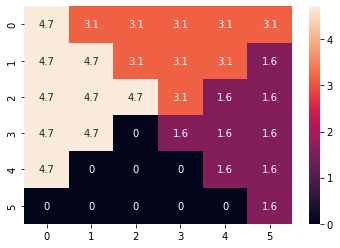

In [19]:
vortex = [
    ['v'] + ['<'] * 5,
    ['v'] * 2 + ['<'] * 3 + ['^'],
    ['v'] * 3 + ['<'] + ['^'] * 2,
    ['v'] * 2 + ['>'] + ['^'] + ['^'] * 2,
    ['v'] * 1 + ['>'] * 3 + ['^'] * 2,
    ['>'] * 5 + ['^'],
]

vortex = np.array(vortex)
rads = [3*pi/2,0,pi/2,pi]
for a,b in zip(list('v>^<'),rads):
    vortex = np.where(vortex == a,b,vortex)
vortex = vortex.astype('float32')
sns.heatmap(vortex,annot=True)

<AxesSubplot:>

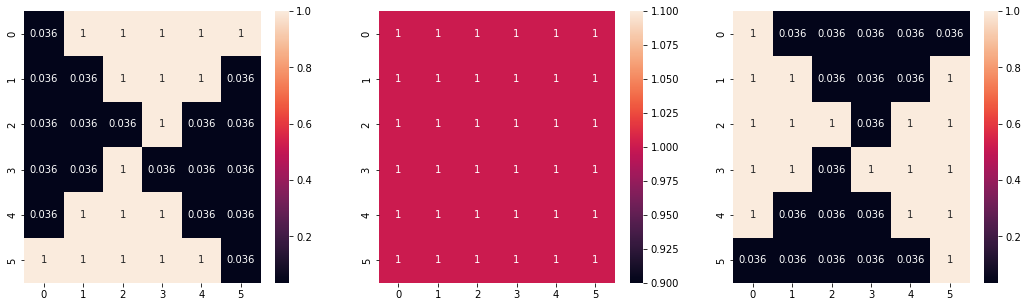

In [20]:
def eps_fun(phi):
    eps_1 = 1 - k_0 * np.sin(phi)**2
    eps_2 = k_0 * np.sin(phi) * np.cos(phi)
    eps_3 = 1 - k_0 * np.cos(phi)**2
    eps = np.stack([eps_1,eps_2,eps_3],2)
    eps = eps.astype('float32')
    return eps


vortex_eps = eps_fun(vortex)
f,ax = plt.subplots(1,3,figsize=(18,5))
sns.heatmap(vortex_eps[...,0],annot=True,ax=ax[0])
# This should be zero and not be used for calculation
# Substitue this with one
vortex_eps[...,1] = 1.0
sns.heatmap(vortex_eps[...,1],annot=True,ax=ax[1])
sns.heatmap(vortex_eps[...,2],annot=True,ax=ax[2])

In [137]:
air_eps = np.ones((6,6),'float32')

In [138]:
grid_plan = np.array([
    ['a'] * 6,
    *[['x'] * 6, 
      ['a'] * 6] * 10,
])
grid_plan

array([['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a'],
       ['x', 'x', 'x', 'x', 'x', 'x'],
       ['a', 'a', 'a', 'a', 'a', 'a']], dtype='<U1')

In [139]:
pml_width = np.array([10,10])
Px,Py = (np.array(grid_plan.shape) * 6 + pml_width * 2).tolist()
grid_eps = np.ones((Px,Py,3))
grid_eps.shape

(146, 56, 3)

In [140]:
grid_eps = np.expand_dims(grid_eps,2)

In [141]:
delta = h / 12

In [142]:
grid = fdtd.Grid(
    shape = (int(Px),int(Py),1,),  
    grid_spacing=delta,
    permittivity=1,
)

In [143]:
grid.inverse_permittivity.shape

(146, 56, 1, 3)

In [144]:


for i in range(len(grid_plan)):
    for j in range(len(grid_plan[0])):
        vortex_obj = fdtd.Object(
            np.expand_dims(vortex_eps,2).copy(),
            name=f'vo_{i}_{j}'
        )
        if grid_plan[i,j] == 'x':
            grid[pml_width[0]+i*6:pml_width[0] + i*6+6,
                 pml_width[1]+j*6:pml_width[0] + j*6+6,
                 0,] = vortex_obj

In [145]:
# x boundaries
# grid[0, :, :] = fdtd.PeriodicBoundary(name="xbounds")
grid[0:10, :, :] = fdtd.PML(name="pml_xlow")
grid[-10:, :, :] = fdtd.PML(name="pml_xhigh")

# y boundaries
# grid[:, 0, :] = fdtd.PeriodicBoundary(name="ybounds")
grid[:, 0:10, :] = fdtd.PML(name="pml_ylow")
grid[:, -10:, :] = fdtd.PML(name="pml_yhigh")

```python
fdtd.LineSource(
    period: Number = 15, # timesteps or seconds
    amplitude: float = 1.0,
    phase_shift: float = 0.0,
    name: str = None,
)
```

In [146]:
grid[10 + 6 // 2, :, 0] = fdtd.LineSource(
    period =  lamd / c0, 
    name="source"
)
grid[Px-(10+6//2), :, 0] = fdtd.LineDetector(name="detector")

```python
fdtd.PML(
    a: float = 1e-8, # stability factor
    name: str = None
)
```

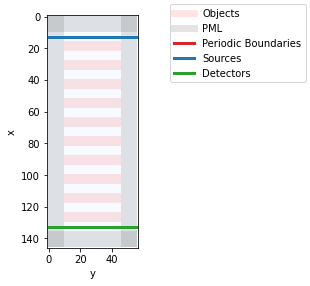

In [147]:
grid.visualize(z=0)

In [148]:
grid.save_simulation('first_run')

'/kaggle/working/fdtd_output/fdtd_output_2022-4-12-14-37-13 (first_run)'

In [152]:
grid.reset()
grid.run(total_time=1000)

100%|██████████| 1000/1000 [00:02<00:00, 460.96it/s]


```python
grid.visualize(
    grid,
    x=None,
    y=None,
    z=None,
    cmap="Blues",
    pbcolor="C3",
    pmlcolor=(0, 0, 0, 0.1),
    objcolor=(1, 0, 0, 0.1),
    srccolor="C0",
    detcolor="C2",
    show=True,
)
```

In [153]:
grid.E.max()

0.022865466422421696

In [165]:
simfolder = grid.save_simulation()  # initializing environment to save simulation data

In [167]:
import os 
with open(os.path.join(simfolder, "grid.txt"), "w") as f:
    f.write(str(grid))
    wavelength = 3e8/grid.source.frequency
    wavelengthUnits = wavelength/grid.grid_spacing
    GD = np.array([grid.x, grid.y, grid.z])
    gridRange = [np.arange(x/grid.grid_spacing) for x in GD]
    objectRange = np.array([[gridRange[0][x.x], gridRange[1][x.y], gridRange[2][x.z]] for x in grid.objects], dtype=object).T
    f.write("\n\nGrid details (in wavelength scale):")
    f.write("\n\tGrid dimensions: ")
    f.write(str(GD/wavelength))
    f.write("\n\tSource dimensions: ")
    f.write(str(np.array([grid.source.x[-1] - grid.source.x[0] + 1, grid.source.y[-1] - grid.source.y[0] + 1, grid.source.z[-1] - grid.source.z[0] + 1])/wavelengthUnits))
    f.write("\n\tObject dimensions: ")
    f.write(str([(max(map(max, x)) - min(map(min, x)) + 1)/wavelengthUnits for x in objectRange]))

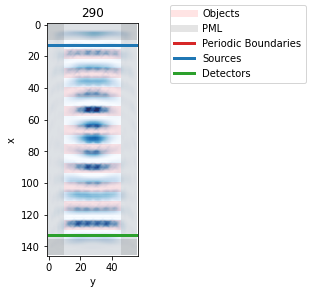

In [168]:
from IPython.display import clear_output # only necessary in jupyter notebooks
grid.reset()
for i in range(300):
    grid.step()  # running simulation 1 timestep a time and animating
    if i % 10 == 0:
        # saving frames during visualization
        plt.figure(figsize=(15,2))
        grid.visualize(z=0, 
                       animate=True, 
                       index=i, 
                       save=True, 
                       folder=simfolder)
        plt.title(f"{i:3.0f}")
        clear_output(wait=True) # only necessary in jupyter notebooks

grid.save_data()  # saving detector readings

In [169]:
video_path = grid.generate_video(delete_frames=False)

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [170]:
from IPython.display import Video
display(Video(video_path, embed=True))